In [1]:
import numpy as np
from neural_net.neuralnet import NeuralNet
import neural_net.activation_functions as af
import pandas as pd
from matplotlib import pyplot as plt
import itertools
import json
import csv
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6 # resize figures
plt.style.use('bmh')

## Preprocessign dat

In [4]:
with open('resources/cruzeirodosul2010daily.csv', 'r') as f:
    reader = csv.DictReader(f, delimiter=';')
    avg_temps = np.array([l['AvgTemp'] for l in reader])
    avg_temps = np.array([np.nan if l=='' else l for l in avg_temps], dtype='float64') # replace missing values with NaN
with open('resources/cruzeirodosul2010daily.csv', 'r') as f:
    reader = csv.DictReader(f, delimiter=';')
    dates = np.array([l['Date'] for l in reader], dtype='int64')
dates[0:5], avg_temps[0:5]

(array([40179, 40180, 40181, 40182, 40183]),
 array([27.14, 27.7 , 28.68, 26.4 , 24.98]))

Grafické znázornění časové řady

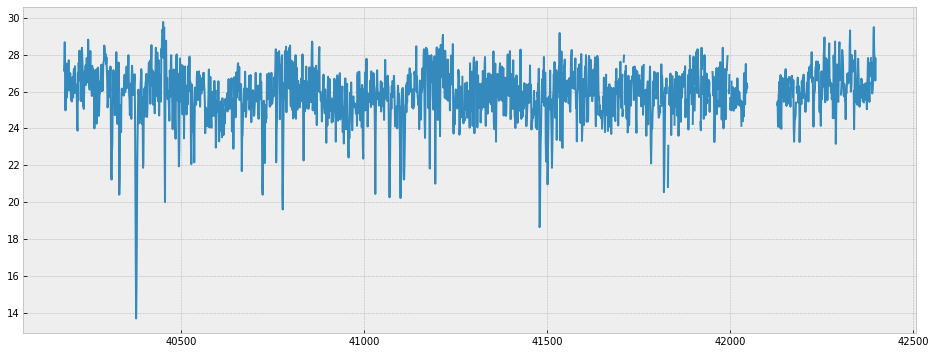

In [3]:
plt.plot(dates, avg_temps)

### Doplnění chybějících hodnot

Ověření předpokladu, že se jedná o časovou řadu

In [22]:
np.all(np.diff(dates) > 0)

True

In [23]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [24]:
nans, x = nan_helper(avg_temps)
avg_temps[nans]= np.interp(x(nans), x(~nans), avg_temps[~nans])

grafický výsledek interpolace

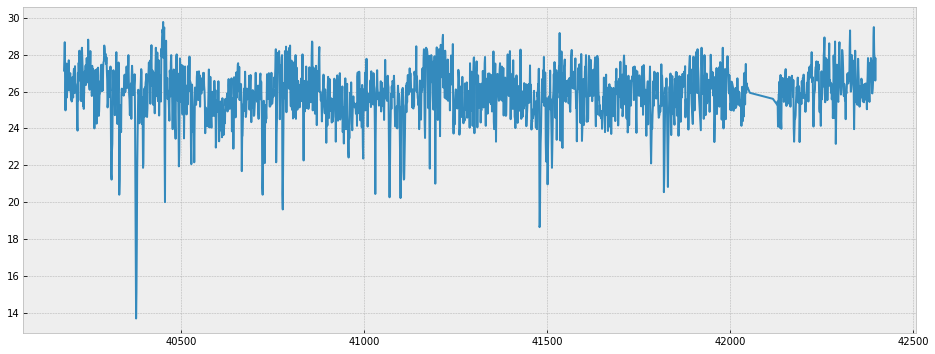

In [25]:
plt.plot(dates, avg_temps)

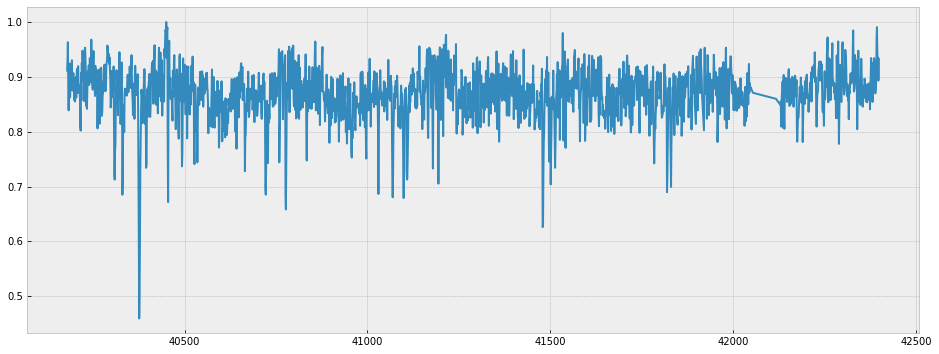

In [28]:
norm_avg_temps = NeuralNet.normalize(avg_temps)
plt.plot(dates, norm_avg_temps)

Detrednování

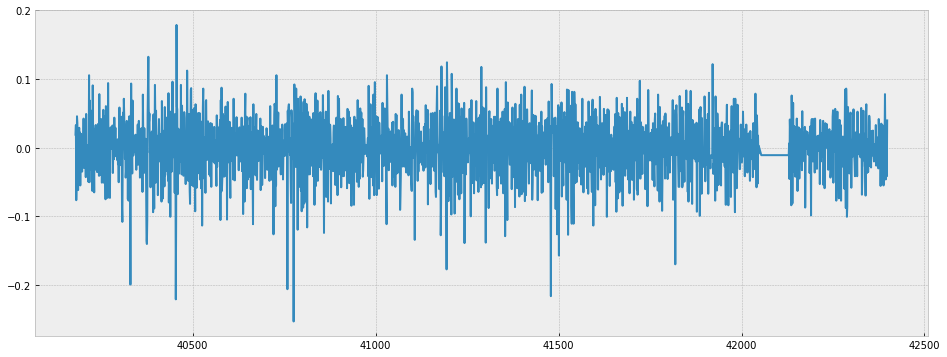

In [37]:
diff_norm_avg_temps = np.diff(norm_avg_temps)
plt.plot(dates[1:], diff_norm_avg_temps)

### Úprava dat pro neuronovou síť
množina byla rozdělena na trénovací a validační v poměru 75%:25%

In [43]:
dataset = [(np.array([x]), np.array([y])) for x, y in zip(dates[1:], diff_norm_avg_temps)]
training_data, test_data = NeuralNet.ratio_list_split(dataset, 0.75)
len(training_data), len(test_data), len(dataset)

(1599, 534, 2133)

# Vypracování

Příprava množiny hyperparametrů

In [44]:
neurons = [10, 5, 3, 1]
epochs = [200]
learning_rates = [0.005, 0.05, 0.1, 0.5]

In [45]:
params = itertools.product(neurons, epochs, learning_rates)
stats = []
for p in params:
    mse_list = []
    nn = NeuralNet([1, p[0], 1], a_functions=[af.sigmoid, af.sigmoid], a_functions_prime=[af.sigmoid_prime, af.sigmoid_prime])
    print(p, end='\n')
    for e in nn.gradient_descent_testdata(
            labeled_training_dataset=training_data,
            labeled_test_dataset=test_data,
            no_epochs=p[1],
            mini_batch_size=1,
            learning_rate=p[2]
            ):
        print('EPOCH: {}\ttest mse: {}'.format(e['epoch'], e['test mse']), end='\r')
        mse_list.append(e['test mse'])
        if e['epoch'] + 1 in [5, 10, 50, 100]: # intermediate reults
            result = {
                'neurons': p[0],
                'epochs': e['epoch'] + 1,
                'learning rate': p[2],
                'mse list' : mse_list,
                'last mse': mse_list[-1]
            }
            stats.append(result)
            print()
            print('FINISHED epoch', e['epoch'])
        if e['epoch'] == p[1] - 1: # last epoch
            result = {
                'neurons': p[0],
                'epochs': e['epoch'] + 1,
                'learning rate': p[2],
                'mse list' : mse_list,
                'last mse': mse_list[-1]
            }
            stats.append(result)
            print()
            print('FINISHED epoch', e['epoch'])
            print()
stats_json = json.dumps(stats)
with open('resources/stats_avgtemp.json', 'w') as f:
    f.write(stats_json)

(10, 200, 0.005)


/mnt/c/Users/ironl/MyCode/neuralnet-project-1o/neural_net/activation_functions.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


EPOCH: 4	test mse: 8.410963604589963e-05
FINISHED epoch 4
EPOCH: 9	test mse: 8.412943720900197e-05
FINISHED epoch 9
EPOCH: 49	test mse: 8.417290066375559e-05
FINISHED epoch 49
EPOCH: 99	test mse: 8.406367399291534e-05
FINISHED epoch 99
EPOCH: 199	test mse: 8.442616816976416e-05
FINISHED epoch 199

(10, 200, 0.05)
EPOCH: 4	test mse: 8.404449956474592e-05
FINISHED epoch 4
EPOCH: 9	test mse: 8.415193529456897e-05
FINISHED epoch 9
EPOCH: 49	test mse: 9.46536089722378e-055
FINISHED epoch 49
EPOCH: 99	test mse: 8.537224771472138e-05
FINISHED epoch 99
EPOCH: 199	test mse: 8.430356551929384e-05
FINISHED epoch 199

(10, 200, 0.1)
EPOCH: 4	test mse: 8.688829400452015e-05
FINISHED epoch 4
EPOCH: 9	test mse: 8.413092461230458e-051
FINISHED epoch 9
EPOCH: 49	test mse: 9.340130161129225e-054
FINISHED epoch 49
EPOCH: 99	test mse: 9.312953001513774e-058
FINISHED epoch 99
EPOCH: 199	test mse: 8.404559714070731e-052
FINISHED epoch 199

(10, 200, 0.5)
EPOCH: 4	test mse: 0.00010105971027230444
FINISHED ep

## Citlivostní analýza

In [52]:
df = pd.read_json('resources/stats_avgtemp.json')
df[['neurons', 'epochs', 'learning rate', 'last mse']]

,neurons,epochs,learning rate,last mse
0,10,5,0.005,0.000084
1,10,10,0.005,0.000084
2,10,50,0.005,0.000084
3,10,100,0.005,0.000084
4,10,200,0.005,0.000084
...,...,...,...,...
75,1,5,0.500,0.000084
76,1,10,0.500,0.000095
77,1,50,0.500,0.000084
78,1,100,0.500,0.000087


In [53]:
index_min = df['last mse'].idxmin()
lowest_mse = df.iloc[index_min, :]
lowest_mse

neurons                                                          1
epochs                                                         200
learning rate                                                  0.5
mse list         [8.405532886318124e-05, 8.525700061992779e-05,...
last mse                                               8.40429e-05
Name: 79, dtype: object

In [54]:
nn = NeuralNet([1, lowest_mse['neurons'], 1], a_functions=[af.sigmoid, af.sigmoid], a_functions_prime=[af.sigmoid_prime, af.sigmoid_prime])
nn.learn(training_data, lowest_mse['epochs'], 1, lowest_mse['learning rate'])

LEARN


/mnt/c/Users/ironl/MyCode/neuralnet-project-1o/neural_net/activation_functions.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


EPOCH:	200	mse: 1.607942476638452e-069
DONE


No handles with labels found to put in legend.


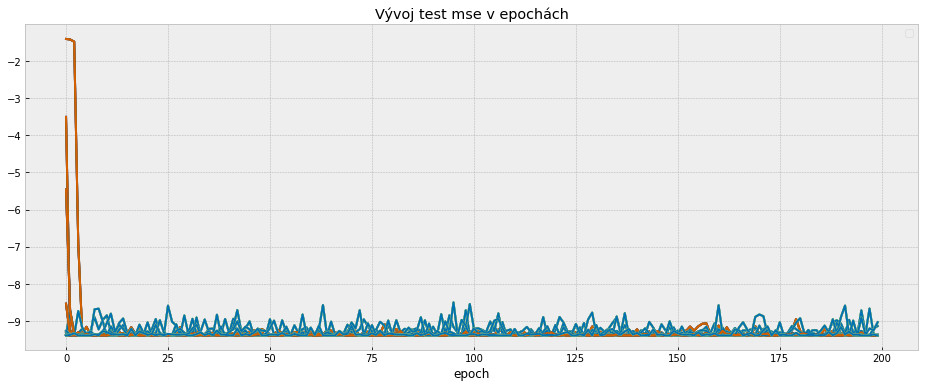

In [75]:
ax, fig = plt.subplots()
# fig.set_xlim([0,200])
# fig.set_ylim([0,0.00020])
plt.xlabel('epoch')
# plt.plot(df['mse list'], label='mse')
for i in df['mse list']:
    plt.plot(np.log(i))
plt.title('Vývoj test mse v epochách')
plt.legend()

/mnt/c/Users/ironl/MyCode/neuralnet-project-1o/neural_net/activation_functions.py:7: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


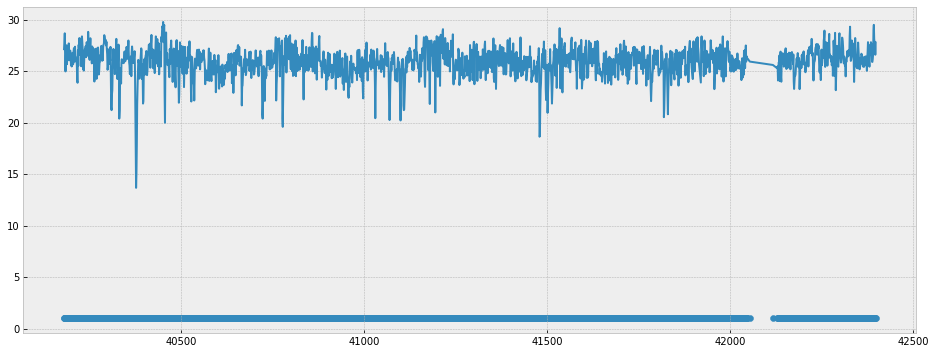

In [80]:
outputs = [nn.feed_forward(np.array([date]))['a'] for date in dates]
plt.plot(dates, avg_temps)
plt.scatter(dates, outputs)